# Exploratory Work<br>
Mira Welner

April 23, 2024

In [1]:
import regex as re
import pickle
from itertools import combinations
import math
from tqdm import tqdm
import requests
import numpy as np
import pandas as pd 
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
from PIRM.PIRMDiscovery import CT_From_Table, Screen
from scipy.stats import ttest_ind, zscore
to_name = pd.read_csv('translator.csv').set_index('gene_num')['gene_name'].to_dict()
to_ensembl = pd.read_csv('translator.csv').set_index('gene_name')['gene_num'].to_dict()
genes_from_paper = [string.strip() for string in open('genes_from_papers.txt', 'r').readlines()]
genes_we_have = pd.read_csv('counts.csv')['Unnamed: 0'].tolist()
genes = [to_ensembl[x] for x in genes_from_paper if to_ensembl[x] in genes_we_have]
counts = np.log1p(pd.read_csv("pe-rna.counts.txt", index_col=0)).loc[genes,:]
meta = pd.read_csv("pe-rna-metadata.csv", header=None, names=["sample", "classification"])
mild = counts[meta.loc[meta['classification'] == 'Mild', 'sample'].tolist()]
severe = counts[meta.loc[meta['classification'] == 'Severe', 'sample'].tolist()]
control = counts[meta.loc[meta['classification'] == 'Control', 'sample'].tolist()]

## Part 1: PIRM on genes with shared pathways vs PIRM on genes without shared pathways

The following function determines, given a pair of genes, if they share any pathways and if so, what are they?

In [2]:
def pathways_in_common(pair):
    gene1, gene2 = pair
    pattern = r'"name":"(.*?)","dataSource":'
    gene_1_pathways = re.findall(pattern, requests.get("https://www.pathwaycommons.org/pc2/top_pathways?q="+to_name[gene1]).text)
    gene_2_pathways = re.findall(pattern, requests.get("https://www.pathwaycommons.org/pc2/top_pathways?q="+to_name[gene2]).text)
    if gene_1_pathways == [] and gene_2_pathways == []:
        return -1
    return [value for value in gene_1_pathways if value in gene_2_pathways]

First, we create two groups, A and B. A has every pair for which the two genes, (G1,G2), share a pathway. B has every pair for which (G1,G2) have no pathways in common. It takes over 20 minutes to create the lists so I pickled them

In [3]:
"""
A = []
A_lengths = []
B = []
pairs = list(combinations(genes, 2))
for pair in tqdm(pairs):
    pathways = pathways_in_common(pair)
    if pathways != -1 and len(pathways):
        A.append(pair)
        A_lengths.append(len(pathways))
    else:
        B.append(pair)
with open('A_B.pkl', 'wb') as f:
    pickle.dump((A,B,A_lengths), f)
"""
with open('A_B.pkl', 'rb') as f:
   A,B,A_lengths = pickle.load(f)
print(len(A))
print(len(B))

167
2759


As you predicted, A is indeed much smaller than B

Now we run each pair through PIRM. The accuracy is can be the raw accuracy for the histograms, or the mcc which is what you needed for the scatterplot

In [4]:
def PIRM_accuracy(case, control, pairs, mcc=False):
    acc = []
    ct_case = CT_From_Table(sample_ids = case.columns, group_label = 'case',  table=case.T)
    ct_ctrl = CT_From_Table(sample_ids = control.columns, group_label = 'control',  table=control.T)
    for pair in pairs:
        TN, TP, FN, FP = [0,0,0,0]
        s = Screen(name='s', ct_case=ct_case, ct_ctrl=ct_ctrl, pair=list(pair))
        for ct in [ct_case, ct_ctrl]:
            for _, sample in ct.ctp.iterrows():
                if s.classify(pd.DataFrame(sample).T)['pred'] == ct.group_label:
                    if ct.group_label == 'case':
                        TP+=1
                    else:
                        TN+=1
                else:
                    if ct.group_label == 'control':
                        FN += 1
                    else:
                        FP += 1
        if mcc:
            if math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)):
                acc.append((TP*TN-FP*FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)))
            else:
                acc.append(0.0)
        else:
            acc.append((TP+TN)/(TP+TN+FP+FN))
    return acc

And create the following histograms

In [5]:
def plot_zscore(ax, name, A, B):
    l = [
        f"PATHWAYS mean:{np.round(np.mean(A),2)} median:{round(np.mean(A),2)} std:{np.round(np.std(A),2)}",
        f"NO PATHWAYS:{np.round(np.mean(B),2)} median:{round(np.mean(B),2)} std:{np.round(np.std(B),2)}",
    ]
    min_value = min(min(A), min(B))
    max_value = max(max(A), max(B))
    num_bins = 10
    bin_width = ((max_value - min_value) / num_bins)
    bins = np.arange(min_value, max_value + bin_width, bin_width)
    z_scores_a = zscore(np.histogram(A, bins=bins)[0])
    z_scores_b = zscore(np.histogram(B, bins=bins)[0])
    ax.bar(bins[:-1]+bin_width/4, z_scores_a, width=bin_width/3, color='g', label=l[0])
    ax.bar(bins[:-1]-bin_width/4, z_scores_b, width=bin_width/3, color='r', label=l[1])
    ax.legend(fontsize=8, loc='lower left')
    ax.set_title(name)
    ax.set_ylim(-3,3)
    ax.set_xlabel('Accuracy')
    ax.set_ylabel('Z-score of Frequency')
    return ax

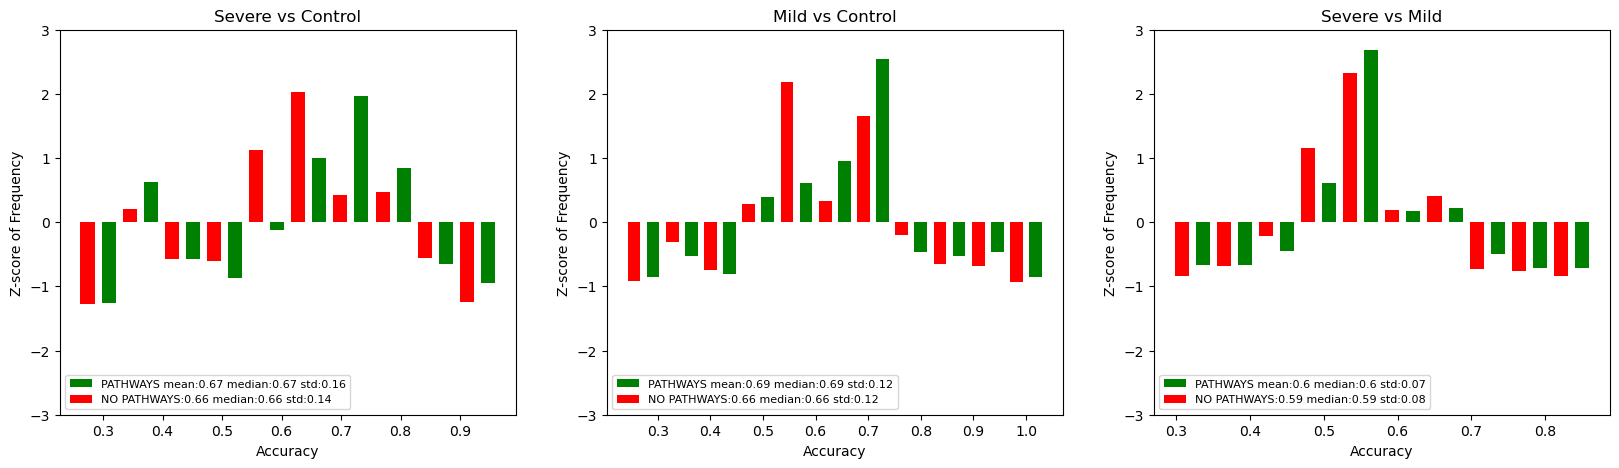

In [6]:
A_sc = PIRM_accuracy(severe, control, A)
B_sc = PIRM_accuracy(severe, control, B)
A_sm = PIRM_accuracy(severe, mild, A)
B_sm = PIRM_accuracy(severe, mild, B)
A_mc = PIRM_accuracy(mild, control, A)
B_mc = PIRM_accuracy(mild, control, B)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0] = plot_zscore(axes[0], 'Severe vs Control', A_sc, B_sc) 
axes[1] = plot_zscore(axes[1], 'Mild vs Control', A_mc, B_mc) 
axes[2] = plot_zscore(axes[2], 'Severe vs Mild', A_sm, B_sm) 
plt.savefig("histograms.png")
plt.show()

Severe vs Control T Test

In [7]:
ttest_ind(A_sc, B_sc)

TtestResult(statistic=1.3905234105239337, pvalue=0.16447581674032996, df=2924.0)

Mild vs Control T Test

In [8]:
ttest_ind(A_mc, B_mc)

TtestResult(statistic=2.840110300663037, pvalue=0.004540971068897001, df=2924.0)

Mild vs Severe T Test

In [9]:
ttest_ind(A_sm, B_sm)

TtestResult(statistic=1.1925042294592458, pvalue=0.23316035669809818, df=2924.0)

## Part 2: Ranking genes by number of individual pathways it shares with other genes
The following dataframe ranks genes from most to fewest individual pathways. Note that it is NOT ranking pairs, it is ranking individual genes

In [10]:
pathway_table = pd.DataFrame(A, columns=['G1', 'G2'])
pathway_table.insert(2, "pathways", A_lengths, True)
d = {key: 0 for key in genes}
def update_dict(row):
    d[row['G1']] += row['pathways']
    d[row['G2']] += row['pathways']
pathway_table.apply(update_dict, axis=1)
ranked_df = pd.DataFrame(list(d.items()), columns=['Code', 'Total Pathways'])
ranked_df.index =  [to_name[k] for k in ranked_df.Code]
ranked_df=ranked_df.drop(columns=['Code']).sort_values(by='Total Pathways', ascending=False)
display(ranked_df)

,Total Pathways
RPL17,120
RPL26,120
RPL23,120
RPL34,120
RPS29,120
RPL27,120
RPL31,120
LEP,114
TNF,73
VEGFA,67


Here is a histogram of the above dataframe for easier visualization

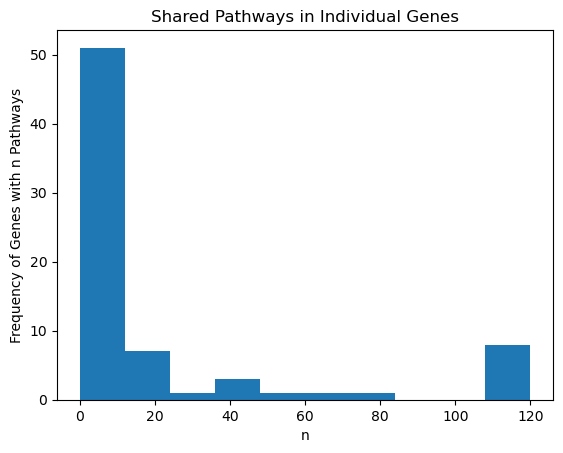

In [11]:
ranked_df.hist(column='Total Pathways', grid=False)
plt.title('Shared Pathways in Individual Genes') 
plt.xlabel('n') 
plt.ylabel('Frequency of Genes with n Pathways') 
plt.show()

It might also be interesting to rank the pairs by how many pathways they share with eachother. There are far too many pairs with no connections to list them all so these are dropped. Every pair included has at least one shared pathway

In [12]:
G1 = [to_name[i] for i in pathway_table.G1]
G2 = [to_name[i] for i in pathway_table.G2]
ranked_pairs = pathway_table.copy()
ranked_pairs.G1 = G1
ranked_pairs.G2 = G2
ranked_pairs = ranked_pairs.sort_values(by='pathways', ascending=False).reset_index(drop=True)
ranked_pairs

,G1,G2,pathways
0,RPL27,RPL34,20
1,RPL27,RPL31,20
2,RPL26,RPL34,20
3,RPL26,RPL31,20
4,RPL26,RPL27,20
5,RPL23,RPL34,20
6,RPL23,RPL31,20
7,RPL23,RPL27,20
8,RPL23,RPL26,20
9,RPL17,RPL34,20


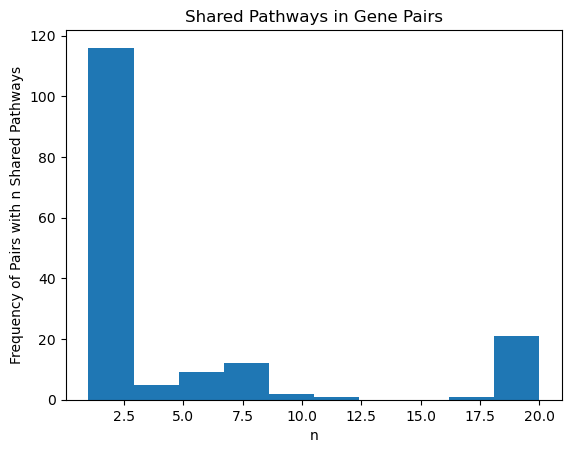

In [13]:
ranked_pairs.hist(column='pathways', grid=False)
plt.title('Shared Pathways in Gene Pairs') 
plt.xlabel('n') 
plt.ylabel('Frequency of Pairs with n Shared Pathways') 
plt.show()

## Part 3: MCC vs Number of Pathways
These three scatterplots show if the number of pathways a pair shares correlates to the mcc value. Note that in this case it is the PAIR that is being analyzed rather than an individual gene because it doesn't really make sense since a single gene does not have an mcc value.

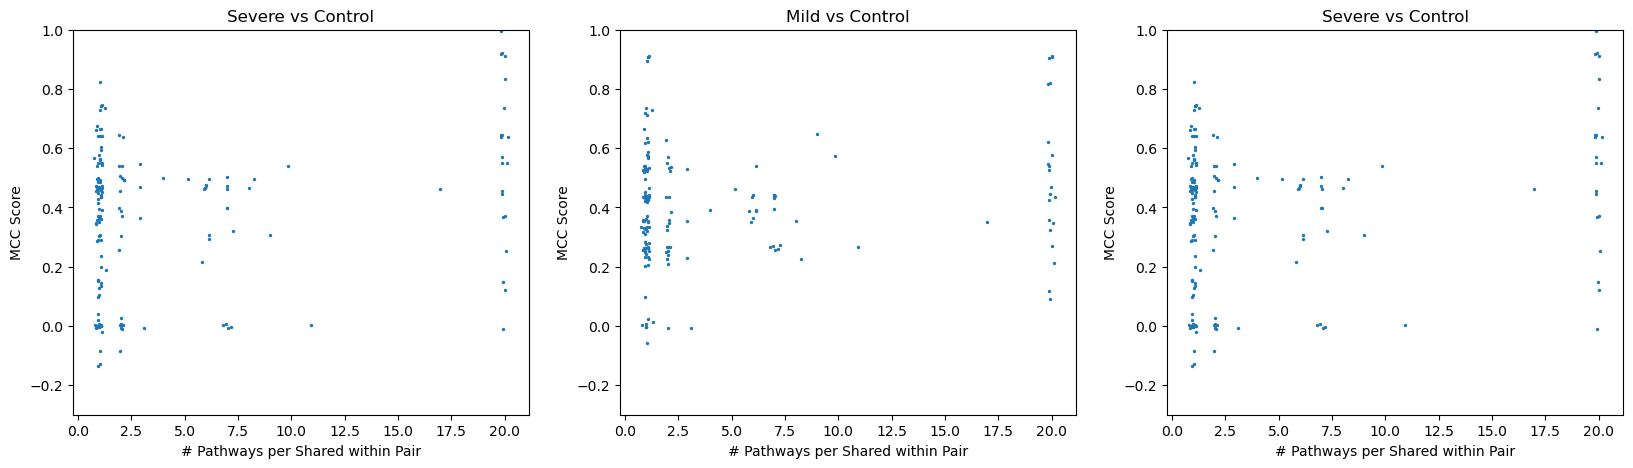

In [14]:
A_sc = PIRM_accuracy(severe, control, A, mcc=True)
A_sm = PIRM_accuracy(severe, mild, A, mcc=True)
A_mc = PIRM_accuracy(mild, control, A, mcc=True)
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
xjitter = np.random.normal(0, 0.1, len(A_lengths))
yjitter = np.random.normal(0,0.005, len(A_lengths))

ax1.scatter(x=A_lengths + xjitter, y=A_sc + yjitter, s=2)
ax1.set_ylim(-0.3,1)
ax1.set_title("Severe vs Control")
ax1.set_ylabel("MCC Score")
ax1.set_xlabel("# Pathways per Shared within Pair")

ax2.scatter(x=A_lengths + xjitter, y=A_mc+yjitter, s=2)
ax2.set_ylim(-0.3,1)
ax2.set_title("Mild vs Control")
ax2.set_ylabel("MCC Score")
ax2.set_xlabel("# Pathways per Shared within Pair")

ax3.scatter(x=A_lengths + xjitter, y=A_sc+yjitter, s=2)
ax3.set_ylim(-0.3,1)
ax3.set_title("Severe vs Control")
ax3.set_ylabel("MCC Score")
ax3.set_xlabel("# Pathways per Shared within Pair")
plt.show()